### ML3 HW3
#### LT5
Borromeo, Chloe<br>
Castanares, Michael Lawrence<br>
Garcia, Fernando Jude<br>
Tan, Allan

Assignment Instructions<br>
Done by LT<br>
Total: 12 points<br>
Submit: Python Notebook (.ipynb)<br>
Task (4pts each method)<br>
Hourly Energy Consumption of Pennsylvania-New Jersey-Maryland Interconnection (PJM) West Region<br>

Using the PJM West Region: 2001-2018 (PJMW) estimated hourly energy consumption data from PJM in Megawatts: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data. Forecast the total daily consumption one month in advance. Compare the MAE and MAPE accuracy of the best:<br><br>
ARIMA<br>
LSTM<br>
GRU<br>

### Load the data

In [16]:
import pandas as pd

In [17]:
file = 'data/PJMW_hourly.csv'

In [18]:
df = pd.read_csv(file)
df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [19]:
df.describe()

,PJMW_MW
count,143206.000000
mean,5602.375089
std,979.142872
min,487.000000
25%,4907.000000
50%,5530.000000
75%,6252.000000
max,9594.000000


Resample to get daily consumption

In [20]:

df.index = pd.to_datetime(df['Datetime'])
df_daily = df.resample('D').sum('PJMW_MW')


# # # Remove Aug 3 2018 because it does not have a complete day's worth of data

df_daily = df_daily[:-1]

In [21]:
df_daily.describe()

,PJMW_MW
count,5968.000000
mean,134431.675268
std,17722.294237
min,72433.000000
25%,121031.750000
50%,132522.500000
75%,146056.500000
max,211070.000000


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


### 1. ARIMA

We will normalize the data later on for LSTM, so do the same here so that MAE will be in the same order of magnitude.

In [23]:
from sklearn.preprocessing import MinMaxScaler

cutoff_train = int(len(df_daily) * 0.8)
cutoff_val = int(len(df_daily) * 0.9)
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(pd.DataFrame(df_daily['PJMW_MW']))
normalized_data = scaler.transform(pd.DataFrame(df_daily['PJMW_MW']))
# Normalize data based on the training set
# mean = df_daily['PJMW_MW'][:cutoff_train].mean(axis=0)
# std = df_daily['PJMW_MW'][:cutoff_train].std(axis=0)
# normalized_data = (df_daily['PJMW_MW'] - mean) / std



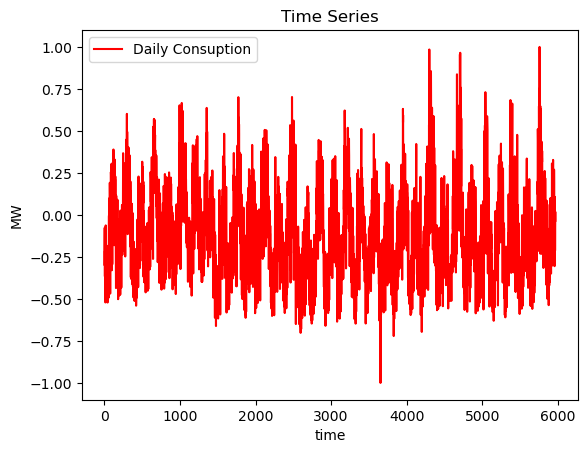

In [24]:
import matplotlib.pyplot as plt


x_axis = range(1, len(normalized_data) + 1)

plt.figure()

plt.plot(x_axis, normalized_data, 'r', label='Daily Consuption')
plt.title('Time Series')
plt.xlabel('time')
plt.ylabel('MW')
plt.legend()

plt.show()

The data needs to be stationary for ARIMA to work. Let's check that.

In [25]:
# ! conda install statsmodels -y

In [26]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test to check stationarity
result = adfuller(normalized_data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.264578
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


The results show that the test statistic value -7.264578 is smaller than the critical value at 1% of -3.431. This suggests the process has no unit root, and in turn that **the time series is stationary or does not have time-dependent structure**.

In [27]:
# ! conda install scikit-learn -y

In [28]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm 
import timeit
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

# Create a differenced series
def difference(dataset, interval=1):
    diff = np.diff(dataset, n=interval)
    return diff

# Invert differenced value
def inverse_difference(history, yhat, interval=1):
   return yhat + history[-interval]

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# Evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # Prepare training dataset
    #X = X.astype('float32')
    days_in_a_month = 30  # Define the number of days in a month
    train_size = int(len(X) - 2 * days_in_a_month)  # Use 2 month validation
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    #history = list(train)


    # Make predictions
    predictions = list()
    for t in tqdm(range(len(test))):
        # Difference data
        diff = difference(history, days_in_a_month)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=30)
        yhat = forecast.predicted_mean[0]
        yhat = inverse_difference(history, yhat, days_in_a_month)
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)

    # Calculate out-of-sample error (MAE)
    mae = mean_absolute_error(test, predictions)
    mape = mean_absolute_percentage_error(test, predictions)
    return mae, mape


In [29]:
import warnings
warnings.filterwarnings("ignore")

# Work on 1/3 of the data

data_subset = normalized_data[len(normalized_data)//3 * 2:,:]

start = timeit.default_timer()
mae, mape = evaluate_arima_model(data_subset, (0, 0, 1))
exec_time = timeit.default_timer() - start
print(f'MAE={mae} MAPE={mape} Execution Time: {exec_time}')


100%|██████████| 60/60 [00:18<00:00,  3.21it/s]

MAE=0.13126981124486514 MAPE=4.044739924459068 Execution Time: 18.66825967899058


Do GridSearch to find the optimal values of p,d and q

In [30]:
from itertools import product

# Define ranges for p, d, q
p_range = range(0, 6)
d_range = range(0, 1)
q_range = range(0, 6)

# Initialize a dictionary to store the results
results = {}
start = timeit.default_timer()
# Iterate over all combinations of p, d, q
for p, d, q in product(p_range, d_range, q_range):
    order = (p, d, q)
    # Evaluate the ARIMA model for the current (p, d, q) order
    try:
        mae, mape = evaluate_arima_model(data_subset, order)
        # Store the result in the dictionary
        results[order] = (mae, mape)
        print(f"Order {order}, MAE: {mae} MAPE: {mape}")
    except:
        print(f"Error trying to converge Order {order}")




100%|██████████| 60/60 [00:13<00:00,  4.52it/s]


Order (0, 0, 0), MAE: 0.20543578816237756 MAPE: 9.010005541861657


100%|██████████| 60/60 [00:16<00:00,  3.67it/s]


Order (0, 0, 1), MAE: 0.13126981124486514 MAPE: 4.044739924459068


100%|██████████| 60/60 [00:20<00:00,  2.93it/s]


Order (0, 0, 2), MAE: 0.11868058835901191 MAPE: 6.144551147225509


100%|██████████| 60/60 [00:25<00:00,  2.33it/s]


Order (0, 0, 3), MAE: 0.12238837287815535 MAPE: 6.705250195096102


100%|██████████| 60/60 [00:35<00:00,  1.68it/s]


Order (0, 0, 4), MAE: 0.11752654868449747 MAPE: 6.104982657677616


100%|██████████| 60/60 [00:53<00:00,  1.12it/s]


Order (0, 0, 5), MAE: 0.12006520805745148 MAPE: 6.314779624498476


100%|██████████| 60/60 [00:09<00:00,  6.17it/s]


Order (1, 0, 0), MAE: 0.13304874219556032 MAPE: 5.266386490651053


100%|██████████| 60/60 [00:20<00:00,  2.96it/s]


Order (1, 0, 1), MAE: 0.12213512482855565 MAPE: 6.551102273642816


100%|██████████| 60/60 [00:28<00:00,  2.10it/s]


Order (1, 0, 2), MAE: 0.12135346877289661 MAPE: 5.854297611313465


100%|██████████| 60/60 [00:50<00:00,  1.19it/s]


Order (1, 0, 3), MAE: 0.1178950327173976 MAPE: 5.046397192749509


100%|██████████| 60/60 [01:04<00:00,  1.08s/it]


Order (1, 0, 4), MAE: 0.11781845016727764 MAPE: 5.033047591197948


100%|██████████| 60/60 [01:16<00:00,  1.28s/it]


Order (1, 0, 5), MAE: 0.11721390624399297 MAPE: 5.018794039999104


100%|██████████| 60/60 [00:14<00:00,  4.28it/s]


Order (2, 0, 0), MAE: 0.13431878785716464 MAPE: 7.617135926886264


100%|██████████| 60/60 [00:41<00:00,  1.46it/s]


Order (2, 0, 1), MAE: 0.12212644585165108 MAPE: 6.332311807221601


100%|██████████| 60/60 [01:15<00:00,  1.26s/it]


Order (2, 0, 2), MAE: 0.11881193298186744 MAPE: 4.9752917056865105


100%|██████████| 60/60 [01:02<00:00,  1.04s/it]


Order (2, 0, 3), MAE: 0.11780891852883002 MAPE: 5.031945489661936


100%|██████████| 60/60 [01:45<00:00,  1.75s/it]


Order (2, 0, 4), MAE: 0.11840966533255673 MAPE: 5.559241232635192


100%|██████████| 60/60 [01:52<00:00,  1.87s/it]


Order (2, 0, 5), MAE: 0.11859954132386834 MAPE: 5.037291720254064


100%|██████████| 60/60 [00:15<00:00,  3.91it/s]


Order (3, 0, 0), MAE: 0.12144074259138847 MAPE: 6.08401715501249


100%|██████████| 60/60 [00:30<00:00,  1.94it/s]


Order (3, 0, 1), MAE: 0.1161411659081349 MAPE: 5.433040728994182


100%|██████████| 60/60 [00:59<00:00,  1.00it/s]


Order (3, 0, 2), MAE: 0.1204624236666766 MAPE: 5.036507588305394


100%|██████████| 60/60 [01:47<00:00,  1.80s/it]


Order (3, 0, 3), MAE: 0.11398420779467507 MAPE: 4.920306316578969


100%|██████████| 60/60 [02:02<00:00,  2.04s/it]


Order (3, 0, 4), MAE: 0.12370084165778832 MAPE: 7.275532490368012


100%|██████████| 60/60 [02:27<00:00,  2.45s/it]


Order (3, 0, 5), MAE: 0.11632615092188127 MAPE: 3.7006313868035887


100%|██████████| 60/60 [00:28<00:00,  2.12it/s]


Order (4, 0, 0), MAE: 0.11582872121178364 MAPE: 5.511614722778248


100%|██████████| 60/60 [01:01<00:00,  1.02s/it]


Order (4, 0, 1), MAE: 0.11470879844078259 MAPE: 5.347726279508023


100%|██████████| 60/60 [01:50<00:00,  1.85s/it]


Order (4, 0, 2), MAE: 0.11608859770703958 MAPE: 5.968891171278772


100%|██████████| 60/60 [01:49<00:00,  1.83s/it]


Order (4, 0, 3), MAE: 0.11373079551024655 MAPE: 6.147532669006181


100%|██████████| 60/60 [02:06<00:00,  2.11s/it]


Order (4, 0, 4), MAE: 0.1091750477782786 MAPE: 4.207169085119912


100%|██████████| 60/60 [02:23<00:00,  2.39s/it]


Order (4, 0, 5), MAE: 0.11074764275995808 MAPE: 5.002313934227559


100%|██████████| 60/60 [00:34<00:00,  1.72it/s]


Order (5, 0, 0), MAE: 0.11524655072695289 MAPE: 5.039190206838715


100%|██████████| 60/60 [01:44<00:00,  1.74s/it]


Order (5, 0, 1), MAE: 0.1145613142063404 MAPE: 4.348065787750679


100%|██████████| 60/60 [02:10<00:00,  2.18s/it]


Order (5, 0, 2), MAE: 0.10850238566378452 MAPE: 5.688198712411833


100%|██████████| 60/60 [02:12<00:00,  2.21s/it]


Order (5, 0, 3), MAE: 0.11080152072201527 MAPE: 4.738415638121561


100%|██████████| 60/60 [02:16<00:00,  2.28s/it]


Order (5, 0, 4), MAE: 0.11687092084595775 MAPE: 4.481784401908148


100%|██████████| 60/60 [02:54<00:00,  2.91s/it]

Order (5, 0, 5), MAE: 0.11634112568102874 MAPE: 5.721616027629851


In [31]:
# Find the (p, d, q) combination with the lowest RMSE
best_order = min(results, key=results.get)
best_mae_arima = results[best_order]
exec_time_arima = timeit.default_timer() - start
# Print the best (p, d, q) combination and the corresponding RMSE
print(f"\nBest Order: {best_order}, Lowest MAE: {best_mae_arima}, Execution Time: {exec_time_arima}")


Best Order: (5, 0, 2), Lowest MAE: (0.10850238566378452, 5.688198712411833), Execution Time: 2604.497070582991


In [98]:
results = []
results.append({'model':'ARIMA', 'order/epochs': best_order, 'MAE': best_mae_arima[0], 'MAPE': best_mae_arima[1]})

### 2. LSTM

In [99]:
import torch
import torch.nn as nn
pytorch_gpu_available = torch.cuda.is_available()
print(f"GPU (CUDA) is available: {pytorch_gpu_available}")
if pytorch_gpu_available:
    print(f"Number of available GPUs: {torch.cuda.device_count()}")


GPU (CUDA) is available: True
Number of available GPUs: 1


In [100]:
from torch.utils.data import Dataset, DataLoader

In [101]:
# convert dates into epoch seconds
df_daily['Time'] = (df_daily.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
ts_data = df_daily[['Time', 'PJMW_MW']]
ts_data.reset_index(inplace=True, drop=True)
ts_data.head()

,Time,PJMW_MW
0,1017619200,121237.0
1,1017705600,127450.0
2,1017792000,127822.0
3,1017878400,136099.0
4,1017964800,136467.0


Normalize the data<br>
Training data is 0-80%<br>
Validation Data is 80-90%<br>
Test Data is last 10%

Do some data engineering to capture seasonality better

In [102]:
ts_data['YEAR'] = df_daily.index.year
ts_data['MONTH'] = df_daily.index.month
ts_data['DAY'] = df_daily.index.day
print(ts_data.head())


         Time   PJMW_MW  YEAR  MONTH  DAY
0  1017619200  121237.0  2002      4    1
1  1017705600  127450.0  2002      4    2
2  1017792000  127822.0  2002      4    3
3  1017878400  136099.0  2002      4    4
4  1017964800  136467.0  2002      4    5


Normalize the Data

In [105]:
cutoff_train = int(len(df_daily) * 0.8)
cutoff_val = int(len(df_daily) * 0.9)
float_data = ts_data.to_numpy()

In [106]:
from sklearn.preprocessing import MinMaxScaler

# Using MinMax Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(float_data)
normalized_data = scaler.transform(float_data)

print(normalized_data[:5,:])

[[-1.         -0.29594553 -1.         -0.45454545 -1.        ]
 [-0.99966482 -0.20631577 -1.         -0.45454545 -0.93333333]
 [-0.99932965 -0.20094924 -1.         -0.45454545 -0.86666667]
 [-0.99899447 -0.08154389 -1.         -0.45454545 -0.8       ]
 [-0.99865929 -0.07623506 -1.         -0.45454545 -0.73333333]]


In [107]:
from torch.utils.data import Dataset

class PJMWBDataset(Dataset):
    def __init__(self, data, lookback, delay, min_index, max_index, step):
        self.data = data
        self.lookback = lookback
        self.delay = delay
        self.min_index = min_index
        self.max_index = max_index if max_index is not None else len(data) - delay - 1
        self.step = step

    def __len__(self):
        return self.max_index - self.min_index - self.lookback + 1

    def __getitem__(self, index):
        # print(self.data.shape)
        i = self.min_index + index + self.lookback
        indices = range(i - self.lookback, i, self.step)
        samples = self.data[indices]
        target = self.data[i + self.delay][1]  # last column column (index -1) is the target variable
        # print(samples.shape)
        return torch.tensor(samples, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)




In [108]:
print(normalized_data.shape)

(5968, 5)


Look back 120 days, 1 data point per day, predict the next 30th day

In [109]:
lookback = 120 # 120 days
step = 1
delay = 30 * 2 # predict next 30 days
batch_size = 120

def generate_loaders():
    NUM_WORKERS = 1



    train_dataset = PJMWBDataset(normalized_data, lookback, delay, 0, cutoff_train, step)
    val_dataset = PJMWBDataset(normalized_data, lookback, delay, cutoff_train + 1, cutoff_val, step)
    test_dataset = PJMWBDataset(normalized_data, lookback, delay, cutoff_val + 1, None, step)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)
    return train_loader, val_loader, test_loader



Baseline - Naive Model

In [110]:
train_loader, val_loader, test_loader = generate_loaders()

def evaluate_naive_method(loader):
    pred_history = []
    target_history = []
    maes = []
    for samples, targets in loader:
        print(samples.shape)
        preds = samples[:, -1 , 1]  # last time step's temperature as prediction
        print(preds.shape)
        # print(f'SAMPLES {samples.shape} PREDS {preds.shape} TARGETS {targets.shape}')
        mae = mean_absolute_error(targets, preds)
        mape = mean_absolute_percentage_error(targets, preds)
        maes.append((mae, mape))
        pred_history += (preds)
        target_history += (targets)
    return min(maes, key = lambda t: t[1]), pred_history, target_history

# Evaluate
naive_mae, pred_history, target_history = evaluate_naive_method(val_loader)
print(f"Best Naive method MAE on validation set: {min(naive_mae)}")


torch.Size([120, 120, 5])
torch.Size([120])
torch.Size([120, 120, 5])
torch.Size([120])
torch.Size([120, 120, 5])
torch.Size([120])
torch.Size([117, 120, 5])
torch.Size([117])
Best Naive method MAE on validation set: 0.316592009953456


In [111]:
results.append({'model':'Naive', 'order/epochs': 'N/A', 'MAE': naive_mae[0], 'MAPE': naive_mae[1]})

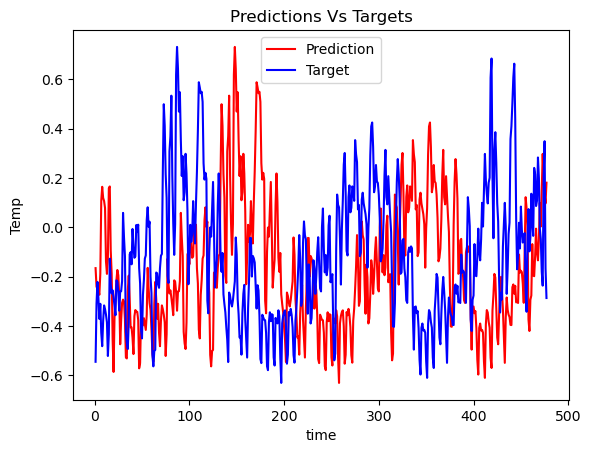

In [112]:
import matplotlib.pyplot as plt


x_axis = range(1, len(pred_history) + 1)

plt.figure()

plt.plot(x_axis, pred_history, 'r', label='Prediction')
plt.plot(x_axis, target_history, 'b', label='Target')
plt.title('Predictions Vs Targets')
plt.xlabel('time')
plt.ylabel('Temp')
plt.legend()

plt.show()

Feed Forward Neural Net

In [113]:
num_epochs = 20

In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class Net(nn.Module):
    def __init__(self, input_shape):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_shape[0] * input_shape[1], 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Determine input shape based on your data structure
input_shape = (lookback // step, normalized_data.shape[-1])
print(input_shape)
ffnn = Net(input_shape)

# Print model architecture
print(ffnn)

(120, 5)
Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=600, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


In [115]:
from torchinfo import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
summary(ffnn, input_size=(1, input_shape[0], input_shape[1]), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 1]                    --
├─Flatten: 1-1                           [1, 600]                  --
├─Linear: 1-2                            [1, 32]                   19,232
├─ReLU: 1-3                              [1, 32]                   --
├─Linear: 1-4                            [1, 1]                    33
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08

In [116]:
def run_model(model, name, num_epochs):
    # Transfer to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    print(device)

    # Loss and optimizer
    criterion = nn.L1Loss()  # MAE in PyTorch
    optimizer = optim.RMSprop(model.parameters())

    # We'll use these lists to store loss history


    # Training loop
    def train_model(model, train_loader, val_loader, epochs):
        train_losses = []
        val_losses = []
        pred_history = []
        target_history = []
        for epoch in range(epochs):
            model.train()
            train_loss = 0.0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs.to(device))
                loss = criterion(outputs, targets.unsqueeze(1).to(device))  # Ensure target matches output shape
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Average loss for this epoch
            train_loss /= len(train_loader)
            train_losses.append(train_loss)  # Store the average loss for plotting

            # Validation
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs.to(device))
                    loss = criterion(outputs, targets.unsqueeze(1).to(device))
                    mape = mean_absolute_percentage_error( targets.cpu(), outputs.cpu())
                    val_loss += loss.item()
                    # train_loss += loss.item()
                    output_shape = outputs.cpu().detach().numpy()[:,0].shape[0]
                    preds_array = outputs.cpu().detach().numpy()[:,0].reshape(output_shape).tolist()
                    target_array = targets.cpu().detach().numpy().reshape(output_shape).tolist()
                    # print(preds_array)
                    pred_history += preds_array
                    target_history += target_array

            # Average validation loss for this epoch
            val_loss /= len(val_loader)
            val_losses.append((val_loss,mape))  # Store the average validation loss for plotting

            # Print statistics
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        return (pred_history, target_history, train_losses, val_losses)
# Train the model

    train_loader, val_loader, test_loader = generate_loaders()

    pred_history, target_history, train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=num_epochs)
    x_axis = range(1, len(pred_history) + 1)

    best_epoch = np.argmin(val_losses) + 1

    print(f'\n\n\nLowest Validation Error: {min(val_losses)} at {best_epoch} epochs')

    plt.figure(figsize=(20,5))
    plt.plot(x_axis, target_history, 'b', label='Target')
    plt.plot(x_axis, pred_history, 'r', label='Prediction')
    plt.title(f'Predictions Vs Targets: {name}')
    plt.xlabel('Cumulative Epoch Time')
    plt.ylabel('Temp')
    plt.legend()

    max_loss_threshold = 10

    # Clip the losses to this threshold
    clipped_train_losses = np.clip(train_losses, None, max_loss_threshold)
    clipped_val_losses = np.clip(val_losses, None, max_loss_threshold)

    # Plotting the loss curves
    epochs = range(1, len(train_losses) + 1)

    plt.figure()

    plt.plot(epochs, clipped_train_losses, 'r', label='Training loss')
    plt.plot(epochs, clipped_val_losses[:,0], 'b', label='Validation loss')
    plt.title(f'Training and validation loss: {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    return min(val_losses, key = lambda t: t[1]), best_epoch, 

cuda
Epoch 1/20, Train Loss: 1.0759, Val Loss: 0.1989
Epoch 2/20, Train Loss: 0.1512, Val Loss: 0.2341
Epoch 3/20, Train Loss: 0.1401, Val Loss: 0.2003
Epoch 4/20, Train Loss: 0.1401, Val Loss: 0.1715
Epoch 5/20, Train Loss: 0.1365, Val Loss: 0.1734
Epoch 6/20, Train Loss: 0.1354, Val Loss: 0.1978
Epoch 7/20, Train Loss: 0.1400, Val Loss: 0.2195
Epoch 8/20, Train Loss: 0.1396, Val Loss: 0.2179
Epoch 9/20, Train Loss: 0.1357, Val Loss: 0.3904
Epoch 10/20, Train Loss: 0.1401, Val Loss: 0.1812
Epoch 11/20, Train Loss: 0.1343, Val Loss: 0.2674
Epoch 12/20, Train Loss: 0.1523, Val Loss: 0.2542
Epoch 13/20, Train Loss: 0.1377, Val Loss: 0.2211
Epoch 14/20, Train Loss: 0.1450, Val Loss: 0.2666
Epoch 15/20, Train Loss: 0.1716, Val Loss: 0.3495
Epoch 16/20, Train Loss: 0.1313, Val Loss: 0.2589
Epoch 17/20, Train Loss: 0.1370, Val Loss: 0.2140
Epoch 18/20, Train Loss: 0.1344, Val Loss: 0.2728
Epoch 19/20, Train Loss: 0.1343, Val Loss: 0.3378
Epoch 20/20, Train Loss: 0.1341, Val Loss: 0.2213



L

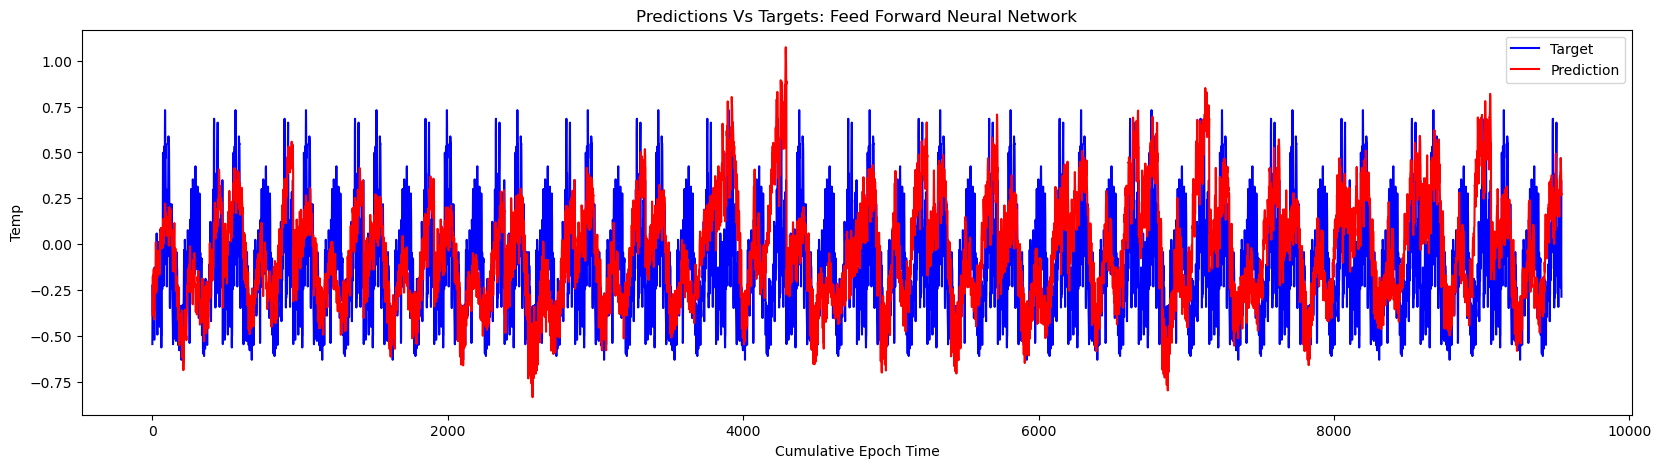

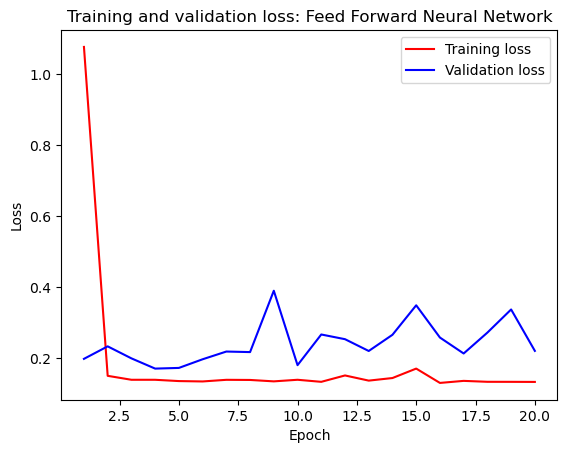

In [117]:
val_losses, epochs = run_model(ffnn, 'Feed Forward Neural Network', num_epochs)

results.append({'model':'FFNN', 'order/epochs': epochs, 'MAE': val_losses[0], 'MAPE': val_losses[1]})

LSTM

In [118]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        # LSTM Layer:
        # - 32 units, as in the Keras model
        # - input_size is the number of features
        self.lstm = nn.LSTM(input_size, 32, batch_first=True)
        # Dense Layer:
        # - 32 (from LSTM) to 1 output (since we're predicting one value)
        self.dense = nn.Linear(32, 1)

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, features)
        lstm_out, _ = self.lstm(x)
        # We only care about the last output of LSTM for prediction
        # Assuming variable length sequences, we take the last output from each batch
        if x.dim() == 3:  # (batch, seq, feature)
            lstm_out = lstm_out[:, -1, :]  # Take last time step
        else:  # If not batched
            lstm_out = lstm_out[-1, :]  # Take last time step

        # Pass through dense layer
        output = self.dense(lstm_out)
        return output

# Define the model with the right input size
input_size = normalized_data.shape[1]  # Number of features in your data
lstm = LSTMModel(input_size)

# Print model summary
print(lstm)

# If you want to see the number of parameters:
total_params = sum(p.numel() for p in lstm.parameters())
print(f"Total parameters: {total_params}")

LSTMModel(
  (lstm): LSTM(5, 32, batch_first=True)
  (dense): Linear(in_features=32, out_features=1, bias=True)
)
Total parameters: 5025


cuda
Epoch 1/20, Train Loss: 0.2348, Val Loss: 0.3812
Epoch 2/20, Train Loss: 0.1668, Val Loss: 0.2143
Epoch 3/20, Train Loss: 0.1567, Val Loss: 0.1996
Epoch 4/20, Train Loss: 0.1510, Val Loss: 0.2460
Epoch 5/20, Train Loss: 0.1471, Val Loss: 0.2196
Epoch 6/20, Train Loss: 0.1422, Val Loss: 0.2290
Epoch 7/20, Train Loss: 0.1398, Val Loss: 0.2343
Epoch 8/20, Train Loss: 0.1384, Val Loss: 0.1828
Epoch 9/20, Train Loss: 0.1355, Val Loss: 0.1970
Epoch 10/20, Train Loss: 0.1338, Val Loss: 0.1771
Epoch 11/20, Train Loss: 0.1320, Val Loss: 0.1993
Epoch 12/20, Train Loss: 0.1297, Val Loss: 0.2075
Epoch 13/20, Train Loss: 0.1291, Val Loss: 0.2422
Epoch 14/20, Train Loss: 0.1267, Val Loss: 0.2157
Epoch 15/20, Train Loss: 0.1254, Val Loss: 0.2008
Epoch 16/20, Train Loss: 0.1235, Val Loss: 0.1768
Epoch 17/20, Train Loss: 0.1208, Val Loss: 0.2161
Epoch 18/20, Train Loss: 0.1218, Val Loss: 0.2074
Epoch 19/20, Train Loss: 0.1202, Val Loss: 0.1985
Epoch 20/20, Train Loss: 0.1182, Val Loss: 0.2372



L

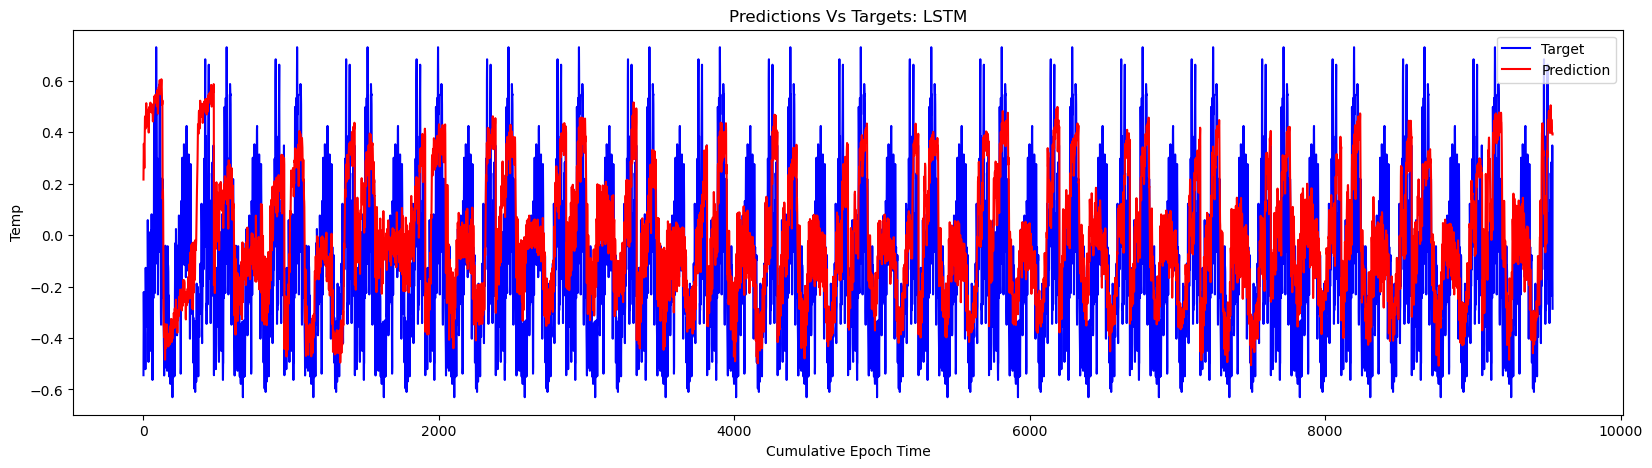

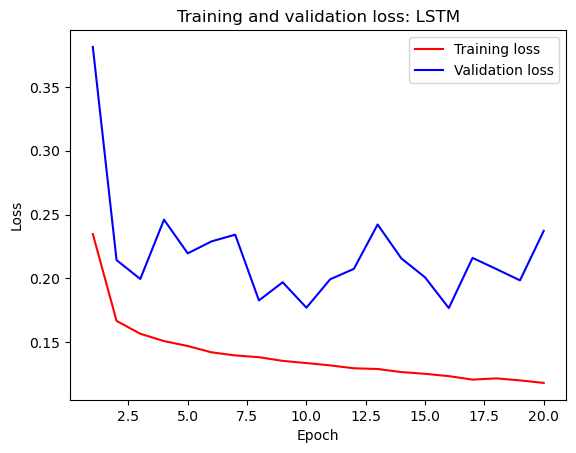

In [119]:
val_losses, epochs = run_model(lstm,'LSTM', num_epochs)


results.append({'model':'LSTM', 'order/epochs': epochs, 'MAE': val_losses[0], 'MAPE': val_losses[1]})

### 3. GRU

In [120]:

class GRUModel(nn.Module):
    def __init__(self, input_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, 32, batch_first=True)
        self.dense = nn.Linear(32, 1)

    def forward(self, x):
        # GRU expects input of shape (batch_size, sequence_length, features)
        gru_out, _ = self.gru(x)
        # We only care about the last output of GRU for prediction
        # Assuming variable length sequences, we take the last output from each batch
        if x.dim() == 3:  # (batch, seq, feature)
            gru_out = gru_out[:, -1, :]  # Take last time step
        else:  # If not batched
            gru_out = gru_out[-1, :]  # Take last time step

        output = self.dense(gru_out)
        return output

# Define the model with the right input size
input_size = normalized_data.shape[1]
gru = GRUModel(input_size)

# Print model summary
print(gru)

total_params = sum(p.numel() for p in gru.parameters())
print(f"Total parameters: {total_params}")

GRUModel(
  (gru): GRU(5, 32, batch_first=True)
  (dense): Linear(in_features=32, out_features=1, bias=True)
)
Total parameters: 3777


cuda
Epoch 1/20, Train Loss: 0.2141, Val Loss: 0.1937
Epoch 2/20, Train Loss: 0.1654, Val Loss: 0.1774
Epoch 3/20, Train Loss: 0.1539, Val Loss: 0.1908
Epoch 4/20, Train Loss: 0.1497, Val Loss: 0.1893
Epoch 5/20, Train Loss: 0.1459, Val Loss: 0.1816
Epoch 6/20, Train Loss: 0.1431, Val Loss: 0.2144
Epoch 7/20, Train Loss: 0.1418, Val Loss: 0.1760
Epoch 8/20, Train Loss: 0.1378, Val Loss: 0.2153
Epoch 9/20, Train Loss: 0.1360, Val Loss: 0.1883
Epoch 10/20, Train Loss: 0.1328, Val Loss: 0.2162
Epoch 11/20, Train Loss: 0.1298, Val Loss: 0.1611
Epoch 12/20, Train Loss: 0.1280, Val Loss: 0.1932
Epoch 13/20, Train Loss: 0.1279, Val Loss: 0.2924
Epoch 14/20, Train Loss: 0.1259, Val Loss: 0.1792
Epoch 15/20, Train Loss: 0.1208, Val Loss: 0.1942
Epoch 16/20, Train Loss: 0.1196, Val Loss: 0.1828
Epoch 17/20, Train Loss: 0.1191, Val Loss: 0.1936
Epoch 18/20, Train Loss: 0.1176, Val Loss: 0.2268
Epoch 19/20, Train Loss: 0.1167, Val Loss: 0.1903
Epoch 20/20, Train Loss: 0.1126, Val Loss: 0.1902



L

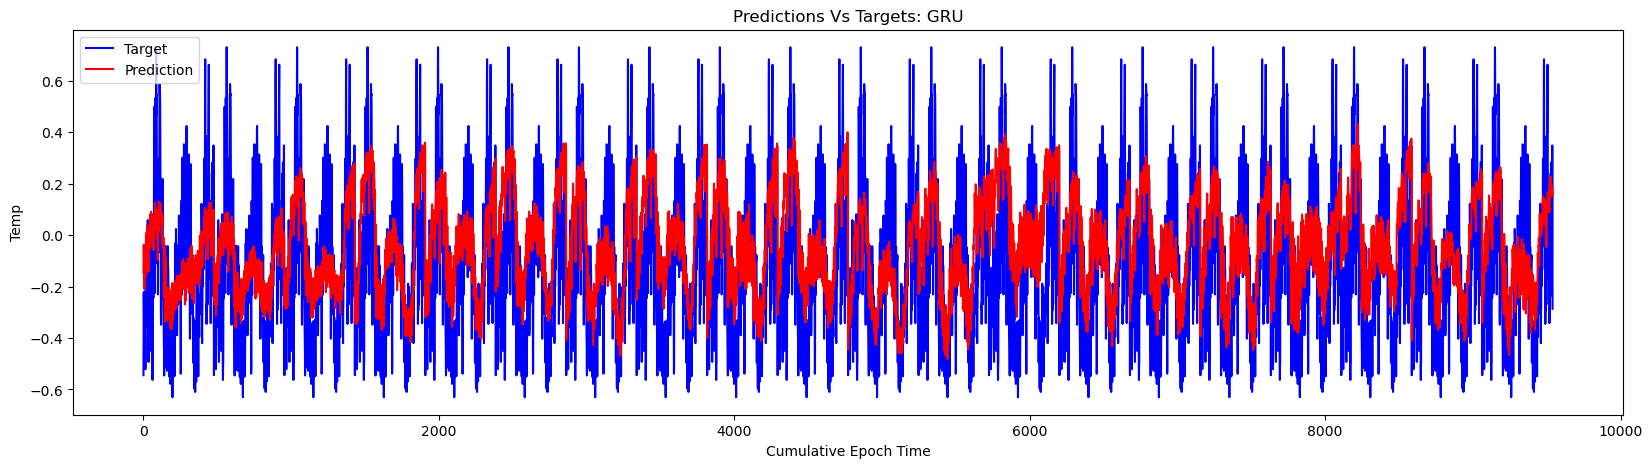

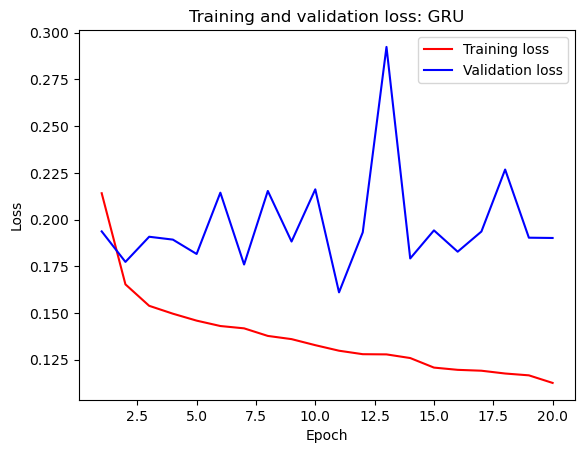

In [121]:
val_losses, epochs = run_model(gru, 'GRU', num_epochs)
results.append({'model':'GRU', 'order/epochs': epochs, 'MAE': val_losses[0], 'MAPE': val_losses[1]})

Stack Recurrent Layers

In [123]:
class GRUModel(nn.Module):
    def __init__(self, input_size):
        super(GRUModel, self).__init__()
        # First GRU Layer:
        self.gru1 = nn.GRU(input_size, 16, dropout=0.1, bidirectional=False, batch_first=True)
        # Here, we manually set recurrent_dropout using a custom wrapper
        self.gru1_dropout = nn.Dropout(0.2)

        # Second GRU Layer:
        self.gru2 = nn.GRU(16, 32, dropout=0.1, bidirectional=False, batch_first=True)
        self.gru2_dropout = nn.Dropout(0.2)

        # Dense Layer:
        self.dense = nn.Linear(32, 1)

        # Activation for the second GRU layer
        self.relu = nn.ReLU()

    def forward(self, x):
        # First GRU layer with recurrent dropout
        gru1_out, _ = self.gru1(x)
        gru1_out = self.gru1_dropout(gru1_out)

        # Second GRU layer
        gru2_out, _ = self.gru2(gru1_out)
        gru2_out = self.gru2_dropout(gru2_out)
        gru2_out = self.relu(gru2_out)

        # We take the last output of the sequence for prediction
        if x.dim() == 3:  # (batch, seq, feature)
            gru2_out = gru2_out[:, -1, :]  # Take last time step
        else:  # If not batched
            gru2_out = gru2_out[-1, :]  # Take last time step

        # Dense layer
        output = self.dense(gru2_out)
        return output

# Define the model with the right input size
input_size = normalized_data.shape[1]  # Number of features in your data
gru_rl = GRUModel(input_size)

# Print model summary
print(gru_rl)

# If you want to see the number of parameters:
total_params = sum(p.numel() for p in gru_rl.parameters())
print(f"Total parameters: {total_params}")

GRUModel(
  (gru1): GRU(5, 16, batch_first=True, dropout=0.1)
  (gru1_dropout): Dropout(p=0.2, inplace=False)
  (gru2): GRU(16, 32, batch_first=True, dropout=0.1)
  (gru2_dropout): Dropout(p=0.2, inplace=False)
  (dense): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)
Total parameters: 5937


cuda
Epoch 1/20, Train Loss: 0.2138, Val Loss: 0.1893
Epoch 2/20, Train Loss: 0.1692, Val Loss: 0.2100
Epoch 3/20, Train Loss: 0.1630, Val Loss: 0.1868
Epoch 4/20, Train Loss: 0.1590, Val Loss: 0.1793
Epoch 5/20, Train Loss: 0.1560, Val Loss: 0.2160
Epoch 6/20, Train Loss: 0.1549, Val Loss: 0.2218
Epoch 7/20, Train Loss: 0.1521, Val Loss: 0.2215
Epoch 8/20, Train Loss: 0.1486, Val Loss: 0.1699
Epoch 9/20, Train Loss: 0.1466, Val Loss: 0.2450
Epoch 10/20, Train Loss: 0.1430, Val Loss: 0.2348
Epoch 11/20, Train Loss: 0.1432, Val Loss: 0.2717
Epoch 12/20, Train Loss: 0.1376, Val Loss: 0.2187
Epoch 13/20, Train Loss: 0.1371, Val Loss: 0.1737
Epoch 14/20, Train Loss: 0.1365, Val Loss: 0.2223
Epoch 15/20, Train Loss: 0.1314, Val Loss: 0.2239
Epoch 16/20, Train Loss: 0.1331, Val Loss: 0.2636
Epoch 17/20, Train Loss: 0.1305, Val Loss: 0.2190
Epoch 18/20, Train Loss: 0.1294, Val Loss: 0.1898
Epoch 19/20, Train Loss: 0.1284, Val Loss: 0.1988
Epoch 20/20, Train Loss: 0.1274, Val Loss: 0.1993



L

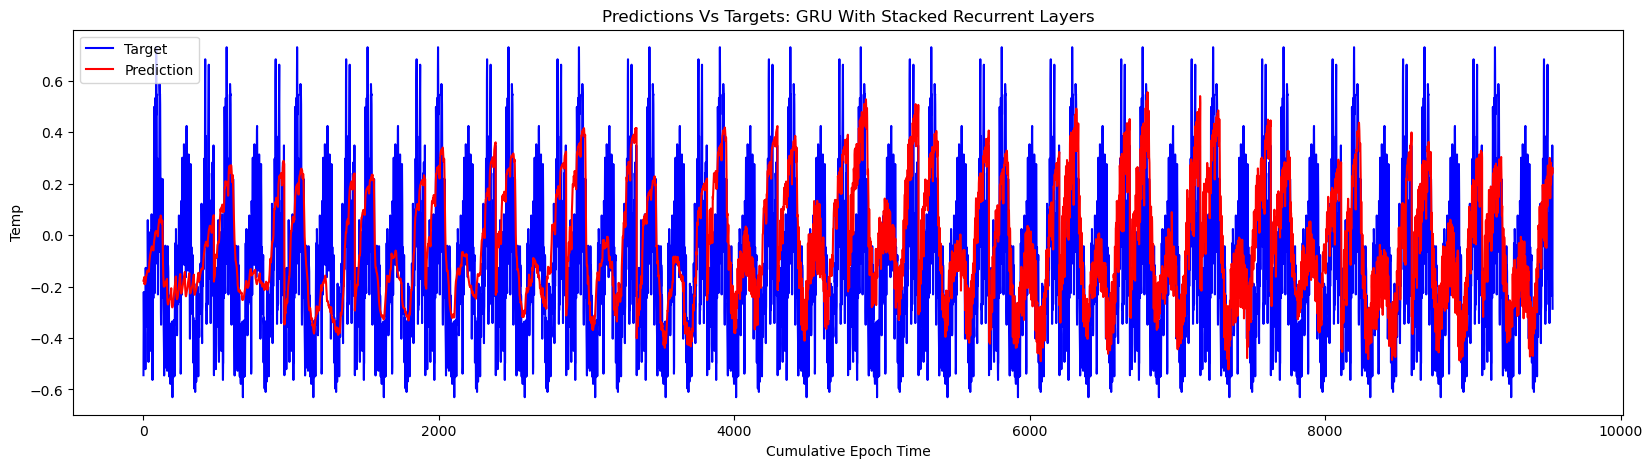

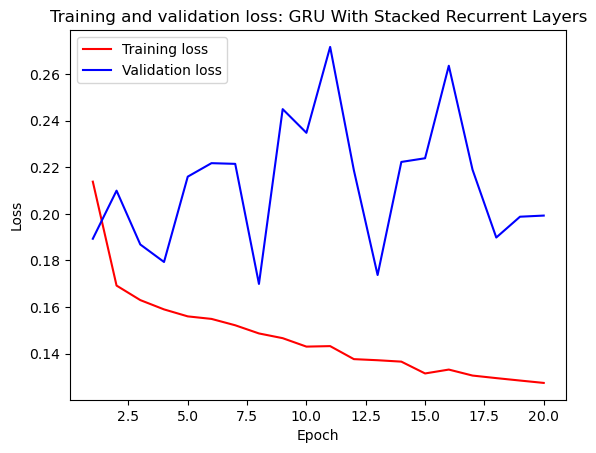

In [124]:
val_losses, epochs = run_model(gru_rl, 'GRU With Stacked Recurrent Layers', num_epochs)
results.append({'model':'GRU With Stacked Recurrent Layers', 'order/epochs': epochs, 'MAE': val_losses[0], 'MAPE': val_losses[1]})

Summary

In [126]:
df_result = pd.DataFrame.from_records(results)
df_result

,model,order/epochs,MAE,MAPE
0,ARIMA,"(5, 0, 2)",0.108502,5.688199
1,Naive,N/A,0.316592,4.112560
2,FFNN,7,0.181204,2.307714
3,LSTM,31,0.182790,2.699578
4,GRU,21,0.193705,1.555852
5,GRU With Stacked Recurrent Layers,15,0.189308,1.768029
